# Inference on Predictive and Causal Effects in High-Dimensional Nonlinear Models

## Impact of 401(k) on  Financial Wealth

We consider estimation of the effect of 401(k) participation
on accumulated assets. 401(k) plans are pension accounts sponsored by employers. The key problem in determining the effect of participation in 401(k) plans on accumulated assets is saver heterogeneity coupled with the fact that the decision to enroll in a 401(k) is non-random. It is generally recognized that some people have a higher preference for saving than others. It also seems likely that those individuals with high unobserved preference for saving would be most likely to choose to participate in tax-advantaged retirement savings plans and would tend to have otherwise high amounts of accumulated assets. The presence of unobserved savings preferences with these properties then implies that conventional estimates that do not account for saver heterogeneity and endogeneity of participation will be biased upward, tending to overstate the savings effects of 401(k) participation.

One can argue that eligibility for enrolling in a 401(k) plan in this data can be taken as exogenous after conditioning on a few observables of which the most important for their argument is income. The basic idea is that, at least around the time 401(k)’s initially became available, people were unlikely to be basing their employment decisions on whether an employer offered a 401(k) but would instead focus on income and other aspects of the job.

### Data

The data set can be downloaded from the github repo


In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b823349697290a67a18217be47049e87492bf79a89165a82edeccf592a2a33a4
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [2]:
# Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import scipy.stats
import warnings
from sklearn.base import BaseEstimator, clone
from IPython.display import Markdown
import wget
import seaborn as sns
warnings.simplefilter('ignore')
np.random.seed(1234)

In [3]:
file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
data = pd.read_csv(file)

In [4]:
data.describe()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
count,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,9.915000e+03,...,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000,9915.000000
mean,3462.871609,3990.459304,63595.865759,30022.505093,33573.360666,1.392864e+04,1.041415e+04,2.156603e+04,1.805153e+04,5.162490e+04,...,0.209178,0.172668,0.121432,0.158548,0.077358,0.144024,0.209682,0.297428,0.215431,0.133434
std,9648.027853,12825.840676,73679.374267,40056.879558,51830.770524,5.490488e+04,5.602886e+04,6.256504e+04,6.352250e+04,9.325339e+04,...,0.406742,0.377979,0.326645,0.365272,0.267171,0.351132,0.407102,0.457150,0.411142,0.340061
min,0.000000,0.000000,0.000000,0.000000,-40000.000000,0.000000e+00,-5.023020e+05,0.000000e+00,-5.023020e+05,-5.023020e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000e+02,-1.350000e+03,3.750000e+02,-5.000000e+02,2.000000e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,48000.000000,7000.000000,10000.000000,1.635000e+03,2.700000e+02,3.325000e+03,1.499000e+03,1.850000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,200.000000,95000.000000,50000.000000,46650.000000,8.765500e+03,6.543500e+03,1.908450e+04,1.652450e+04,6.920000e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,100000.000000,153000.000000,300000.000000,150000.000000,300000.000000,1.430298e+06,1.430298e+06,1.536798e+06,1.536798e+06,1.687115e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
data.head()

,ira,a401,hval,hmort,hequity,nifa,net_nifa,tfa,net_tfa,tfa_he,...,i3,i4,i5,i6,i7,a1,a2,a3,a4,a5
0,0,0,69000,60150,8850,100,-3300,100,-3300,5550,...,1,0,0,0,0,0,1,0,0,0
1,0,0,78000,20000,58000,61010,61010,61010,61010,119010,...,0,1,0,0,0,0,0,0,1,0
2,1800,0,200000,15900,184100,7549,7049,9349,8849,192949,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,2487,-6013,2487,-6013,-6013,...,0,0,1,0,0,1,0,0,0,0
4,0,0,300000,90000,210000,10625,-2375,10625,-2375,207625,...,0,1,0,0,0,0,0,1,0,0


In [6]:
readme = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.md"
filename = wget.download(readme)
Markdown(open(filename, 'r').read())

# Pension 401(k) data set

## Description
Data set on financial wealth and 401(k) plan participation. The source of this data set is the `hdm` package in `R`. It was created on 2/20/2023, by calling the `data(pension)` command in `R` after loading the `hdm` package and then writing the created dataframe to a csv file.

## Format
Dataframe with the following variables (amongst others):

**p401**

participation in 401(k)

**e401**

eligibility for 401(k)

**a401**

401(k) assets

**tw**

total wealth (in US $)

**tfa**

financial assets (in US $)

**net_tfa**

net financial assets (in US $)

**nifa**

non-401k financial assets (in US $)

**net_nifa**

net non-401k financial assets

**net_n401**

net non-401(k) assets (in US $)

**ira**

individual retirement account (IRA)

**inc**

income (in US $)

**age**

age

**fsize**

family size

**marr**

married

**pira**

participation in IRA

**db**

defined benefit pension

**hown**

home owner

**educ**

education (in years)

**male**

male

**twoearn**

two earners

**nohs, hs, smcol, col**

dummies for education: no high-school, high-school, some college, college

**hmort**

home mortage (in US $)

**hequity**

home equity (in US $)

**hval**

home value (in US $)

**i1-i7**

are income category indicators, 

**a1-a5**

are age category indicators

**icat** 

is the categorical variable that produces i1-i7. 

**ecat** 

is the categorical variable that generates education dummies (no high school, high school, some college, college). 

**Dum91**

is a dummy for 1991 which is equal to 1 for all observations because we are only use the 1991 SIPP. 

**tfa_he**

is net_tfa + home equity.

**zhat**

outcome of first stage prediction in instrumental variable analysis, from the academic paper that introduced this data


## Details
The sample is drawn from the 1991 Survey of Income and Program Participation (SIPP) and consists of 9,915 observations. The observational units are household reference persons aged 25-64 and spouse if present. Households are included in the sample if at least one person is employed and no one is self-employed. The data set was analysed in Chernozhukov and Hansen (2004) and Belloni et al. (2014) where further details can be found. They examine the effects of 401(k) plans on wealth using data from the Survey of Income and Program Participation using 401(k) eligibility as an instrument for 401(k) participation.

## References
V. Chernohukov, C. Hansen (2004). The impact of 401(k) participation on the wealth distribution: An instrumental quantile regression analysis. The Review of Economic and Statistics 86 (3), 735–751.

A. Belloni, V. Chernozhukov, I. Fernandez-Val, and C. Hansen (2014). Program evaluation with high-dimensional data. Working Paper.

The data consist of 9,915 observations at the household level drawn from the 1991 Survey of Income and Program Participation (SIPP).  All the variables are referred to 1990. We use net financial assets (*net\_tfa*) as the outcome variable, $Y$,  in our analysis. The net financial assets are computed as the sum of IRA balances, 401(k) balances, checking accounts, saving bonds, other interest-earning accounts, other interest-earning assets, stocks, and mutual funds less non mortgage debts.

Among the $9915$ individuals, $3682$ are eligible to participate in the program. The variable *e401* indicates eligibility and *p401* indicates participation, respectively.

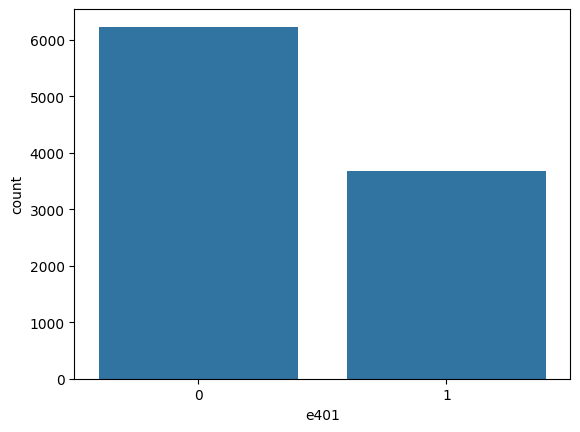

In [7]:
sns.countplot(data, x='e401')
plt.show()

Eligibility is highly associated with financial wealth:

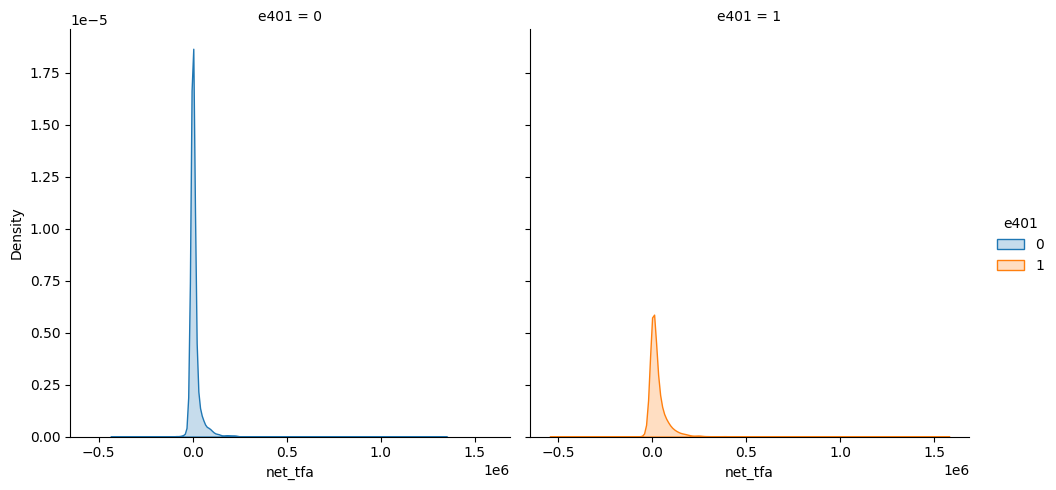

In [8]:
sns.displot(data=data, x='net_tfa', kind='kde', col='e401', hue='e401', fill=True)
plt.show()

The unconditional APE of e401 is about $19559$:

In [9]:
e1 = data[data['e401'] == 1]['net_tfa']
e0 = data[data['e401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

19559


Among the $3682$ individuals that  are eligible, $2594$ decided to participate in the program. The unconditional APE of p401 is about $27372$:

In [10]:
e1 = data[data['p401'] == 1]['net_tfa']
e0 = data[data['p401'] == 0]['net_tfa']
print(f'{np.mean(e1) - np.mean(e0):.0f}')

27372


As discussed, these estimates are biased since they do not account for saver heterogeneity and endogeneity of participation.

In [11]:
y = data['net_tfa'].values
Z = data['e401'].values
D = data['p401'].values
X = data.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
               'hval', 'hmort', 'hequity',
               'nifa', 'net_nifa', 'net_n401', 'ira',
               'dum91', 'icat', 'ecat', 'zhat',
               'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
               'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)
X.columns

Index(['age', 'inc', 'fsize', 'educ', 'db', 'marr', 'male', 'twoearn', 'pira',
       'nohs', 'hs', 'smcol', 'col', 'hown'],
      dtype='object')

### We define a transformer that constructs the engineered features for controls

In [12]:
!pip install formulaic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 2.2 MB/s eta 0:00:00


In [13]:
from sklearn.base import TransformerMixin
from formulaic import Formula


class FormulaTransformer(TransformerMixin, BaseEstimator):

    def __init__(self, formula, array=False):
        self.formula = formula
        self.array = array

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        df = Formula(self.formula).get_model_matrix(X)
        if self.array:
            return df.values
        return df

In [14]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown")

In [15]:
transformer.fit_transform(X).head()

,"poly(age, degree=6, raw=True)[0]","poly(age, degree=6, raw=True)[1]","poly(age, degree=6, raw=True)[2]","poly(age, degree=6, raw=True)[3]","poly(age, degree=6, raw=True)[4]","poly(age, degree=6, raw=True)[5]","poly(inc, degree=8, raw=True)[0]","poly(inc, degree=8, raw=True)[1]","poly(inc, degree=8, raw=True)[2]","poly(inc, degree=8, raw=True)[3]",...,"poly(educ, degree=4, raw=True)[2]","poly(educ, degree=4, raw=True)[3]","poly(fsize, degree=2, raw=True)[0]","poly(fsize, degree=2, raw=True)[1]",male,marr,twoearn,db,pira,hown
0,31,961,29791,923521,28629151,887503681,28146,792197316,22297185656136,627576587477603856,...,1728,20736,5,25,0,1,0,0,0,1
1,52,2704,140608,7311616,380204032,19770609664,32634,1064977956,34754490616104,1134178046765937936,...,4096,65536,5,25,0,0,0,0,0,1
2,50,2500,125000,6250000,312500000,15625000000,52206,2725466436,142285700757816,7428167293762542096,...,1331,14641,3,9,1,1,1,0,1,1
3,28,784,21952,614656,17210368,481890304,45252,2047743504,92664489043008,4193253458174198016,...,3375,50625,4,16,0,1,1,0,0,0
4,42,1764,74088,3111696,130691232,5489031744,33126,1097331876,36350215724376,1204137246085679376,...,1728,20736,3,9,0,0,0,1,0,1


In [16]:
transformer = FormulaTransformer("0 + poly(age, degree=6, raw=True) + poly(inc, degree=8, raw=True) "
                                 "+ poly(educ, degree=4, raw=True) + poly(fsize, degree=2, raw=True) "
                                 "+ male + marr + twoearn + db + pira + hown", array=True)

# Instrumental Variables: Effect of 401k Participation on Financial Assets

## Double ML IV under Partial Linearity

Now, we consider estimation of average treatment effects of participation in 401k, i.e. `p401`, with the binary instrument being eligibility in 401k, i.e. `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates. We consider a partially linear structural equation model:
\begin{eqnarray*}
Y & := & g_Y(\epsilon_Y) D + f_Y(A, X, \epsilon_Y),  \\
D & := & f_D(Z, X, A, \epsilon_D), \\
Z & := & f_Z(X, \epsilon_Z),\\
A & : =  & f_A(X, \epsilon_A), \\
X & := &  \epsilon_X,
\end{eqnarray*}
where $A$ is a vector of un-observed confounders.

Under this structural equation model, the average treatment effect:
\begin{align}
\alpha = E[Y(1) - Y(0)]
\end{align}
can be identified by the moment restriction:
\begin{align}
E[(\tilde{Y} - \alpha \tilde{D}) \tilde{Z}] = 0
\end{align}
where for any variable $V$, we denote with $\tilde{V} = V - E[V|X]$.

In [17]:
modely = make_pipeline(transformer, StandardScaler(), LassoCV())
modeld = make_pipeline(transformer, StandardScaler(), LassoCV())
modelz = make_pipeline(transformer, StandardScaler(), LassoCV())

In [18]:
resy = y - modely.fit(X, y).predict(X)
resZ = Z - modelz.fit(X, Z).predict(X)  # instrument is e401k (eligibility)
resD = D - modeld.fit(X, D).predict(X)  # treatment is p401k (participation)

In [19]:
np.mean(resy * resZ) / np.mean(resD * resZ)

12959.470227125954

Recall if we want to do inference, we need to either use the theoretically driven penalty parameter for Lasso or perform cross-fitting.

### DML with Non-Linear ML Models and Cross-fitting

In [20]:
def dml(X, Z, D, y, modely, modeld, modelz, *, nfolds, classifier=False):
    '''
    DML for the Partially Linear Model setting with cross-fitting

    Input
    -----
    X: the controls
    Z: the instrument
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    modelz: the ML model for predicting the instrument Z
    nfolds: the number of folds in cross-fitting
    classifier: bool, whether the modeld is a classifier or a regressor

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the treatment D
    Zhat: the cross-fitted predictions for the instrument Z
    resy: the outcome residuals
    resD: the treatment residuals
    resZ: the instrument residuals
    epsilon: the final residual-on-residual OLS regression residual
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1)  # out-of-fold predictions for y
    # out-of-fold predictions for D
    # use predict or predict_proba dependent on classifier or regressor for D
    if classifier:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    else:
        Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1)
        Zhat = cross_val_predict(modelz, X, Z, cv=cv, n_jobs=-1)
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat
    resZ = Z - Zhat
    # final stage ols based point estimate and standard error
    point = np.mean(resy * resZ) / np.mean(resD * resZ)
    epsilon = resy - point * resD
    var = np.mean(epsilon**2 * resZ**2) / np.mean(resD * resZ)**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon

In [21]:
def summary(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'rmse Z': np.sqrt(np.mean(resZ**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         'accuracy Z': np.mean(np.abs(resZ) < .5),  # binary classification accuracy of model for Z
                         }, index=[name])

#### Double Lasso with Cross-Fitting

In [22]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lassod = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lassoz = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
result = dml(X, Z, D, y, lassoy, lassod, lassoz, nfolds=3)

In [23]:
table = summary(*result, X, Z, D, y, name='double lasso')
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048


#### Using a Penalized Logistic Regression for D

Note the default logistic regression uses an  ℓ2  penalty. You can use the  ℓ1  penalty as well, but computation will take longer.

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lgrd = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
lgrz = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
result = dml(X, Z, D, y, lassoy, lgrd, lgrz, nfolds=3, classifier=True)

In [25]:
table = pd.concat([table, summary(*result, X, Z, D, y, name='lasso/logistic')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645


### Random Forests

In [26]:
rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfz = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
result = dml(X, Z, D, y, rfy, rfd, rfz, nfolds=3, classifier=True)

In [27]:
table = pd.concat([table, summary(*result, X, Z, D, y, name='random forest')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645
random forest,12899.771516,1961.510987,9055.209982,16744.333050,55344.379983,0.415391,0.444691,0.744629,0.691377


### Decision Trees

In [28]:
dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
dtrz = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
result = dml(X, Z, D, y, dtry, dtrd, dtrz, nfolds=3, classifier=True)

In [29]:
table = pd.concat([table, summary(*result, X, Z, D, y, name='decision tree')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645
random forest,12899.771516,1961.510987,9055.209982,16744.333050,55344.379983,0.415391,0.444691,0.744629,0.691377
decision tree,13592.318101,2140.587262,9396.767068,17787.869135,59843.942695,0.416830,0.447080,0.738477,0.678467


### Boosted Trees

In [30]:
gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
gbfz = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
result = dml(X, Z, D, y, gbfy, gbfd, gbfz, nfolds=3, classifier=True)

In [31]:
table = pd.concat([table, summary(*result, X, Z, D, y, name='boosted forest')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645
random forest,12899.771516,1961.510987,9055.209982,16744.333050,55344.379983,0.415391,0.444691,0.744629,0.691377
decision tree,13592.318101,2140.587262,9396.767068,17787.869135,59843.942695,0.416830,0.447080,0.738477,0.678467
boosted forest,13495.133235,1966.962370,9639.886989,17350.379480,56250.631090,0.414948,0.443947,0.742713,0.693898


## Semi-Crossfitting and AutoML

In [32]:
!pip install flaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 6.0 MB/s eta 0:00:00


In [33]:
from flaml import AutoML

flamly = make_pipeline(transformer, AutoML(time_budget=100, task='regression', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamld = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamlz = make_pipeline(transformer, AutoML(time_budget=100, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))

In [34]:
flamly.fit(X, y)
besty = make_pipeline(transformer, clone(flamly[-1].best_model_for_estimator(flamly[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [35]:
flamld.fit(X, D)
bestd = make_pipeline(transformer, clone(flamld[-1].best_model_for_estimator(flamld[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [36]:
flamlz.fit(X, Z)
bestz = make_pipeline(transformer, clone(flamlz[-1].best_model_for_estimator(flamlz[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune
INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [37]:
result = dml(X, Z, D, y, besty, bestd, bestz, nfolds=3, classifier=True)

In [38]:
table = pd.concat([table, summary(*result, X, Z, D, y, name='automl (semi-cfit)')])
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645
random forest,12899.771516,1961.510987,9055.209982,16744.333050,55344.379983,0.415391,0.444691,0.744629,0.691377
decision tree,13592.318101,2140.587262,9396.767068,17787.869135,59843.942695,0.416830,0.447080,0.738477,0.678467
boosted forest,13495.133235,1966.962370,9639.886989,17350.379480,56250.631090,0.414948,0.443947,0.742713,0.693898
automl (semi-cfit),13310.467512,1903.891817,9578.839551,17042.095473,54004.857132,0.414320,0.445102,0.747453,0.694402


## Inference Robust to Weak Identification

In [39]:
def robust_inference(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, epsilon, X, Z, D, y, *, grid, alpha=0.05):
    '''
    Inference in the partially linear IV model that is robust to weak identification.
    grid: grid of theta values to search over when trying to identify the confidence region
    alpha: confidence level
    '''
    n = X.shape[0]
    thr = scipy.stats.chi2.ppf(1 - alpha, df=1)
    accept = []
    for theta in grid:
        moment = (resy - theta * resD) * resZ
        test = n * np.mean(moment)**2 / np.var(moment)
        if test <= thr:
            accept.append(theta)
    return accept

In [40]:
region = robust_inference(*result, X, Z, D, y, grid=np.linspace(0, 20000, 10000))

In [41]:
np.min(region), np.max(region)

(9580.95809580958, 17043.70437043704)

We find that the robust inference confidence region is almost identical to the normal based inference. We are most probably in the strong instrument regime. We can check the t-statistic for the effect of the instrument on the treatment, to verify that

In [42]:
beta = np.mean(resZ * resD) / np.mean(resZ**2)
var_beta = np.mean((resD - beta * resZ)**2 * resZ**2) / np.mean(resZ**2)**2
se_beta = np.sqrt(var_beta / resD.shape[0])
print(np.abs(beta) / se_beta)

87.57673416377114


Since the $t$-statistic is very large, the normal based approximation and confidence intervals should be fine. We can also get this $t$-statistic by simply using the statsmodels package

In [43]:
from statsmodels.api import OLS
OLS(endog=resD, exog=resZ, hasconst=False).fit(cov_type='HC0').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.556
Model:                            OLS   Adj. R-squared (uncentered):              0.556
Method:                 Least Squares   F-statistic:                              7670.
Date:                Mon, 31 Mar 2025   Prob (F-statistic):                        0.00
Time:                        03:18:09   Log-Likelihood:                         -1272.4
No. Observations:                9915   AIC:                                      2547.
Df Residuals:                    9914   BIC:                                      2554.
Df Model:                           1                                                  
Covariance Type:                  HC0                                                  
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6959      0.008     87.577      0.000       0.680       0.711
==============================================================================
Omnibus:                     2329.706   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4652.931
Skew:                          -1.418   Prob(JB):                         0.00
Kurtosis:                       4.794   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity robust (HC0)
"""

# Interactive IV Model and LATE

Now, we consider estimation of local average treatment effects (LATE) of participation `p401`, with the binary instrument `e401`. As before, $Y$ denotes the outcome `net_tfa`, and $X$ is the vector of covariates.  Here the structural equation model is:
\begin{eqnarray}
Y &:=&  f_Y (D, X, A, \epsilon_Y) \\
D &:= & f_D(Z, X, A, \epsilon_D) \in \{0,1\},  \\
Z  &:= & f_Z(X,\epsilon_Z) \in \{0,1\},  \\
X &:=&  \epsilon_X, \quad A = \epsilon_A,
\end{eqnarray}
where $\epsilon$'s are all exogenous and independent,
and
$$
z \mapsto f_D(z , A, X, \epsilon_D) \text{ is weakly increasing (weakly monotone)}.
$$
and $A$ is a vector of unobserved confounders. Note that in our setting monotonicity is satisfied, since participation is only feasible when it is eligible. Thus we have that $D=0$ whenever $Z=0$. Thus it can only be that $f_D(1, A, X, \epsilon_D) \geq 0 = f_D(0, A, X, \epsilon_D)$.

In this case, we can estimate the local average treatment effect (LATE):
$$
\alpha = E[Y(1) - Y(0) | D(1) > D(0)]
$$
This can be identified using the Neyman orthogonal moment equation:
\begin{align}
E\left[g(1, X) - g(0, X) + H(Z) (Y - g(Z, X)) - \alpha \cdot  (m(1, X) - m(0, X) + H(Z) (D - m(Z, X))\right] = 0
\end{align}
where
\begin{align}
g(Z,X) =~& E[Y|Z,X],\\
m(Z,X) =~& E[D|Z,X],\\
H(Z) =~& \frac{Z}{Pr(Z=1|X)} - \frac{1 - Z}{1 - Pr(Z=1|X)}
\end{align}

In [44]:
def iiv(X, Z, D, y, modely0, modely1, modeld1, modeld0, modelz, *, trimming=0.01, nfolds):
    '''
    DML for the Interactive IV Model setting with cross-fitting

    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely0: the ML model for predicting the outcome y in the Z=0 population
    modely1: the ML model for predicting the outcome y in the Z=1 population
    modeld0: the ML model for predicting the treatment D in the Z=0 population
    modeld1: the ML model for predicting the treatment D in the Z=1 population
    modelz: the ML model for predicting the instrument Z
    trimming: threshold below which to trim propensities
    nfolds: the number of folds in cross-fitting

    Output
    ------
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    yhat: the cross-fitted predictions for the outcome y
    Dhat: the cross-fitted predictions for the outcome D
    resy: the outcome residuals
    resD: the treatment residuals
    drhat: the doubly robust quantity for each sample
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=123)

    yhat0, yhat1 = np.zeros(y.shape), np.zeros(y.shape)
    Dhat0, Dhat1 = np.zeros(D.shape), np.zeros(D.shape)

    # we will fit a model E[Y| D, X] by fitting a separate model for D==0
    # and a separate model for D==1.
    for train, test in cv.split(X, y):
        # train an outcome model on training data that received Z=0 and predict outcome on all data in test set
        yhat0[test] = clone(modely0).fit(X.iloc[train][Z[train] == 0], y[train][Z[train] == 0]).predict(X.iloc[test])
        # train an outcome model on training data that received Z=1 and predict outcome on all data in test set
        yhat1[test] = clone(modely1).fit(X.iloc[train][Z[train] == 1], y[train][Z[train] == 1]).predict(X.iloc[test])
        # train a treatment model on training data that received Z=0 and predict treatment on all data in test set
        if np.mean(D[train][Z[train] == 0]) > 0:  # it could be that D=0, whenever Z=0 deterministically
            modeld0_ = clone(modeld0).fit(X.iloc[train][Z[train] == 0], D[train][Z[train] == 0])
            Dhat0[test] = modeld0_.predict_proba(X.iloc[test])[:, 1]
        # train a treamtent model on training data that received Z=1 and predict treatment on all data in test set
        if np.mean(D[train][Z[train] == 1]) < 1:  # it could be that D=1, whenever Z=1 deterministically
            modeld1_ = clone(modeld1).fit(X.iloc[train][Z[train] == 1], D[train][Z[train] == 1])
            Dhat1[test] = modeld1_.predict_proba(X.iloc[test])[:, 1]
        else:
            Dhat1[test] = 1

    # prediction of treatment and outcome for observed instrument
    yhat = yhat0 * (1 - Z) + yhat1 * Z
    Dhat = Dhat0 * (1 - Z) + Dhat1 * Z
    # propensity scores
    Zhat = cross_val_predict(modelz, X, Z, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
    Zhat = np.clip(Zhat, trimming, 1 - trimming)
    # doubly robust quantity for every sample
    HZ = Z / Zhat - (1 - Z) / (1 - Zhat)
    drZ = yhat1 - yhat0 + (y - yhat) * HZ
    drD = Dhat1 - Dhat0 + (D - Dhat) * HZ
    point = np.mean(drZ) / np.mean(drD)
    psi = drZ - point * drD
    Jhat = np.mean(drD)
    var = np.mean(psi**2) / Jhat**2
    stderr = np.sqrt(var / X.shape[0])
    return point, stderr, yhat, Dhat, Zhat, y - yhat, D - Dhat, Z - Zhat, drZ, drD

In [45]:
def summary(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD, X, Z, D, y, *, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return pd.DataFrame({'estimate': point,  # point estimate
                         'stderr': stderr,  # standard error
                         'lower': point - 1.96 * stderr,  # lower end of 95% confidence interval
                         'upper': point + 1.96 * stderr,  # upper end of 95% confidence interval
                         'rmse y': np.sqrt(np.mean(resy**2)),  # RMSE of model that predicts outcome y
                         'rmse D': np.sqrt(np.mean(resD**2)),  # RMSE of model that predicts treatment D
                         'rmse Z': np.sqrt(np.mean(resZ**2)),  # RMSE of model that predicts treatment D
                         'accuracy D': np.mean(np.abs(resD) < .5),  # binary classification accuracy of model for D
                         'accuracy Z': np.mean(np.abs(resZ) < .5),  # binary classification accuracy of model for Z
                         }, index=[name])

In [46]:
cv = KFold(n_splits=5, shuffle=True, random_state=123)
lassoy = make_pipeline(transformer, StandardScaler(), LassoCV(cv=cv))
lgrd = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
lgrz = make_pipeline(transformer, StandardScaler(), LogisticRegressionCV(cv=cv))
result = iiv(X, Z, D, y, lassoy, lassoy, lgrd, lgrd, lgrz, nfolds=3)

In [47]:
tableiiv = summary(*result, X, Z, D, y, name='lasso/logistic')
tableiiv

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
lasso/logistic,11156.281081,1633.455754,7954.707803,14357.854359,54023.763725,0.277216,0.444185,0.890267,0.687645


In [48]:
rfy = make_pipeline(transformer, RandomForestRegressor(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfd = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
rfz = make_pipeline(transformer, RandomForestClassifier(n_estimators=100, min_samples_leaf=10, ccp_alpha=.001))
result = iiv(X, Z, D, y, rfy, rfy, rfd, rfd, rfz, nfolds=3)

In [49]:
tableiiv = pd.concat([tableiiv, summary(*result, X, Z, D, y, name='random forest')])
tableiiv

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
lasso/logistic,11156.281081,1633.455754,7954.707803,14357.854359,54023.763725,0.277216,0.444185,0.890267,0.687645
random forest,11336.163502,1658.364731,8085.768630,14586.558374,55753.380436,0.274906,0.444404,0.888956,0.688956


In [50]:
dtry = make_pipeline(transformer, DecisionTreeRegressor(min_samples_leaf=10, ccp_alpha=.001))
dtrd = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
dtrz = make_pipeline(transformer, DecisionTreeClassifier(min_samples_leaf=10, ccp_alpha=.001))
result = iiv(X, Z, D, y, dtry, dtry, dtrd, dtrd, dtrz, nfolds=3)

In [51]:
tableiiv = pd.concat([tableiiv, summary(*result, X, Z, D, y, name='decision trees')])
tableiiv

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
lasso/logistic,11156.281081,1633.455754,7954.707803,14357.854359,54023.763725,0.277216,0.444185,0.890267,0.687645
random forest,11336.163502,1658.364731,8085.768630,14586.558374,55753.380436,0.274906,0.444404,0.888956,0.688956
decision trees,10079.539801,1830.535033,6491.691136,13667.388466,60264.865788,0.295846,0.447080,0.865255,0.678467


In [52]:
gbfy = make_pipeline(transformer, GradientBoostingRegressor(max_depth=2, n_iter_no_change=5))
gbfd = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
gbfz = make_pipeline(transformer, GradientBoostingClassifier(max_depth=2, n_iter_no_change=5))
result = iiv(X, Z, D, y, gbfy, gbfy, gbfd, gbfd, gbfz, nfolds=3)

In [53]:
tableiiv = pd.concat([tableiiv, summary(*result, X, Z, D, y, name='boosted trees')])
tableiiv

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
lasso/logistic,11156.281081,1633.455754,7954.707803,14357.854359,54023.763725,0.277216,0.444185,0.890267,0.687645
random forest,11336.163502,1658.364731,8085.768630,14586.558374,55753.380436,0.274906,0.444404,0.888956,0.688956
decision trees,10079.539801,1830.535033,6491.691136,13667.388466,60264.865788,0.295846,0.447080,0.865255,0.678467
boosted trees,11368.873094,1652.339565,8130.287546,14607.458641,54804.079197,0.274020,0.443948,0.890267,0.691074


## Semi-Crossfitting

In [54]:
from flaml import AutoML
flamly0 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamly1 = make_pipeline(transformer, AutoML(time_budget=60, task='regression', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamld1 = make_pipeline(transformer, AutoML(time_budget=60, task='classification', early_stop=True,
                                            eval_method='cv', n_splits=3, metric='r2', verbose=0))
flamlz = make_pipeline(transformer, AutoML(time_budget=60, task='classification', early_stop=True,
                                           eval_method='cv', n_splits=3, metric='r2', verbose=0))

In [55]:
flamly0.fit(X[Z == 0], y[Z == 0])
besty0 = make_pipeline(transformer, clone(flamly0[-1].best_model_for_estimator(flamly0[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [56]:
flamly1.fit(X[Z == 1], y[Z == 1])
besty1 = make_pipeline(transformer, clone(flamly1[-1].best_model_for_estimator(flamly1[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [57]:
from sklearn.dummy import DummyClassifier
bestd0 = DummyClassifier()  # since D=0 whenever Z=0

In [58]:
flamld1.fit(X[Z == 1], D[Z == 1])
bestd1 = make_pipeline(transformer, clone(flamld1[-1].best_model_for_estimator(flamld1[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [59]:
flamlz.fit(X, Z)
bestz = make_pipeline(transformer, clone(flamlz[-1].best_model_for_estimator(flamlz[-1].best_estimator)))

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


In [60]:
result = iiv(X, Z, D, y, besty0, besty1, bestd0, bestd1, bestz, nfolds=3)

In [61]:
tableiiv = pd.concat([tableiiv, summary(*result, X, Z, D, y, name='automl (semi-cfit)')])
tableiiv

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
lasso/logistic,11156.281081,1633.455754,7954.707803,14357.854359,54023.763725,0.277216,0.444185,0.890267,0.687645
random forest,11336.163502,1658.364731,8085.768630,14586.558374,55753.380436,0.274906,0.444404,0.888956,0.688956
decision trees,10079.539801,1830.535033,6491.691136,13667.388466,60264.865788,0.295846,0.447080,0.865255,0.678467
boosted trees,11368.873094,1652.339565,8130.287546,14607.458641,54804.079197,0.274020,0.443948,0.890267,0.691074
automl (semi-cfit),11809.282152,1621.312010,8631.510613,14987.053692,55936.391804,0.278216,0.445102,0.890267,0.694402


Comparing with the PLR model

In [62]:
table

,estimate,stderr,lower,upper,rmse y,rmse D,rmse Z,accuracy D,accuracy Z
double lasso,12805.275717,1846.632406,9185.876202,16424.675232,54111.994234,0.414217,0.443826,0.745335,0.688048
lasso/logistic,12517.127820,1844.765364,8901.387706,16132.867934,54111.994234,0.414706,0.444185,0.746041,0.687645
random forest,12899.771516,1961.510987,9055.209982,16744.333050,55344.379983,0.415391,0.444691,0.744629,0.691377
decision tree,13592.318101,2140.587262,9396.767068,17787.869135,59843.942695,0.416830,0.447080,0.738477,0.678467
boosted forest,13495.133235,1966.962370,9639.886989,17350.379480,56250.631090,0.414948,0.443947,0.742713,0.693898
automl (semi-cfit),13310.467512,1903.891817,9578.839551,17042.095473,54004.857132,0.414320,0.445102,0.747453,0.694402


We find that the PLR model overestimates the effect by around 1k; though both sets of results have overlapping confidence intervals.

In [63]:
def iivm_robust_inference(point, stderr, yhat, Dhat, Zhat, resy, resD, resZ, drZ, drD, X, Z, D, y, *,
                          grid, alpha=0.05):
    '''
    Inference in the partially linear IV model that is robust to weak identification.
    grid: grid of theta values to search over when trying to identify the confidence region
    alpha: confidence level
    '''
    n = X.shape[0]
    thr = scipy.stats.chi2.ppf(1 - alpha, df=1)
    accept = []
    for theta in grid:
        moment = drZ - theta * drD
        test = n * np.mean(moment)**2 / np.var(moment)
        if test <= thr:
            accept.append(theta)
    return accept

In [64]:
region = iivm_robust_inference(*result, X, Z, D, y, grid=np.linspace(0, 20000, 10000))

In [65]:
np.min(region), np.max(region)

(8630.863086308631, 14987.498749874987)

We find again that the robust inference confidence region is almost identical to the normal based inference. We are most probably in the strong instrument regime. We can check the t-statistic for the effect of the instrument on the treatment to verify this.

# Using EconML

There exist nice packages out there that can help us do our estimation with the simple call of a function. Such packages include EconML (Python) and DoubleML (Python and R). We run through PLR IV with EconML and IIVM with DoubleML to illustrate.

In [66]:
!pip install econml==0.14.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 29.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 11.2 MB/s eta 0:00:00
  Created wheel for econml: filename=econml-0.14.1-cp311-cp311-linux_x86_64.whl size=3143121 sha256=503c891846d410399aba567246cf94d2b6583f54ec6b9f52f03b698081f8edaf
  Stored in directory: /root/.cache/pip/wheels/d3/61/61/e2435e71f948d4f85ef6535653e0ed4bc5d8583028cc92df8e
  Created wheel for shap: filename=shap-0.41.0-cp311-cp311-linux_x86_64.whl size=518508 sha256=480152faeb57854eeb4ce73be3b3d5336d5a9095386

In [67]:
W = StandardScaler().fit_transform(transformer.fit_transform(X))

In [76]:
from econml.iv.dml import OrthoIV

cv = KFold(n_splits=5, shuffle=True, random_state=123)
plriv = OrthoIV(model_y_xw=LassoCV(cv=cv),
                model_t_xw=LogisticRegressionCV(cv=cv),
                model_z_xw=LogisticRegressionCV(cv=cv),
                cv=3, discrete_treatment=True, discrete_instrument=True, random_state=123)

ImportError: cannot import name '_print_elapsed_time' from 'sklearn.utils' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py)

In [75]:
plriv.fit(y, D, Z=Z, W=W)

NameError: name 'plriv' is not defined

In [ ]:
plriv.summary()

EconML does not yet support LATE estimation under the fully interactive IV model.

It does support however a more general IV model where the variables `X` are allowed to alter the effect heterogeneity and the compliance heterogeneity, but the un-observed confounder is not allowed to jointly alter both. In other words, it assumes a structural equation model of the form:
\begin{eqnarray*}
Y & := & g_Y(X, \epsilon_Y) D + f_Y(A, X, \epsilon_Y),  \\
D & := & f_D(Z, X, A, \epsilon_D), \\
Z & := & f_Z(X, \epsilon_Z),\\
A & : =  & f_A(X, \epsilon_A), \\
X & := &  \epsilon_X,
\end{eqnarray*}
where $A$ is a vector of un-observed confounders. Under these assumptions the average treatment effect is identifiable (not just the local average treatment effect). In particular, the average treatment effect can be identified as:
\begin{align}
\alpha := E[Y(1) - Y(0)] = E\left[ \frac{Cov(Y, Z\mid X)}{Cov(D, Z\mid X)} \right] = E\left[ \frac{E[\tilde{Y} \tilde{Z}\mid X]}{E[\tilde{Z} \tilde{D}\mid X]} \right]
\end{align}
where for any variable $V$ we have $\tilde{V}=V-E[V|X]$.

However, the variance of this method can be quite larger than the LATE method, since it uses a local compliance measure, i.e. $E[\tilde{Z} \tilde{D}\mid X]$, which can be small for some regions of $X$. This extra variance stems from the fact that we are going after a more challenging causal quantity which is the average treatment effect, instead of the local average treatment effect, and hence we need to re-weight the data based on compliance levels, conditional on observable covariates $X$.

In [ ]:
from econml.iv.dr import LinearDRIV

driv = LinearDRIV(model_y_xw=LassoCV(cv=cv),
                  model_t_xw=LogisticRegressionCV(cv=cv),
                  model_t_xwz=LogisticRegressionCV(cv=cv),
                  model_tz_xw=LassoCV(cv=cv),
                  flexible_model_effect=LassoCV(cv=cv),
                  projection=True,
                  discrete_instrument=True, discrete_treatment=True, cv=3, cov_clip=0.01, random_state=123)

In [ ]:
driv.fit(y, D, Z=Z, W=W)

In [ ]:
driv.summary()

# Using the DoubleML Package

We run through IIVM using `DoubleML` below to illustrate. The `DoubleML` package internally builds on `mlr3`. We use the meta package `mlr3` to generate predictions with machine learning methods. A comprehensive introduction and description of the `mlr3` package is provided in the [mlr3book](https://mlr3book.mlr-org.com/). A list of all learners that you can use in `mlr3` can be found [here](https://mlr3extralearners.mlr-org.com/articles/learners/list_learners.html). The entry in the columns *mlr3 Package* and *Packages* indicate which packages must be installed/loaded in your R session.

You find additional information about `DoubleML` on the package on the package website https://docs.doubleml.org/ and the R documentation page https://docs.doubleml.org/r/stable/.

In [70]:
!pip install doubleml~=0.7.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 3.6 MB/s eta 0:00:00


In [71]:
from doubleml import DoubleMLData
dml_data = DoubleMLData.from_arrays(W, y, D, z=Z)
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): ['z']
No. Observations: 9915

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9915 entries, 0 to 9914
Columns: 29 entries, X1 to z
dtypes: float64(29)
memory usage: 2.2 MB



In [72]:
import doubleml as dml


class RegWrapper(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y):
        self.clf_ = clone(self.clf).fit(X, y)
        return self

    def predict(self, X):
        return self.clf_.predict_proba(X)[:, 1]


dml_plr_obj = dml.DoubleMLPLIV(dml_data,
                               LassoCV(cv=cv),
                               RegWrapper(LogisticRegressionCV(cv=cv)),
                               RegWrapper(LogisticRegressionCV(cv=cv)),
                               n_folds=3)
print(dml_plr_obj.fit())

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): ['z']
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: partialling out
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_l: LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Learner ml_m: RegWrapper(clf=LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))
Learner ml_r: RegWrapper(clf=LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))
Out-of-sample Performance:
Learner ml_l RMSE: [[54387.28876229]]
Learner ml_m RMSE: [[0.44393454]]
Learner ml_r RMSE: [[0.41512502]]

-----------

In [73]:
import doubleml as dml


class Wrapper(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf

    def fit(self, X, y):
        if np.mean(y) == 0 or np.mean(y) == 1:
            self.clf_ = np.mean(y)
        else:
            self.clf_ = clone(self.clf).fit(X, y)
        self.classes_ = np.array([0, 1])
        return self

    def predict_proba(self, X):
        probs = np.zeros((X.shape[0], 2))
        if self.clf_ == 0:
            probs[:, 0] = 1
            return probs
        if self.clf_ == 1:
            probs[:, 1] = 1
            return probs
        return self.clf_.predict_proba(X)

    def predict(self, X):
        return self.predict_proba(X)[:, 1] >= .5


dml_plr_obj = dml.DoubleMLIIVM(dml_data,
                               LassoCV(cv=cv),
                               Wrapper(LogisticRegressionCV(cv=cv)),
                               Wrapper(LogisticRegressionCV(cv=cv)),
                               n_folds=3)
print(dml_plr_obj.fit())

================== DoubleMLIIVM Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26']
Instrument variable(s): ['z']
No. Observations: 9915

------------------ Score & algorithm ------------------
Score function: LATE
DML algorithm: dml2

------------------ Machine learner   ------------------
Learner ml_g: LassoCV(cv=KFold(n_splits=5, random_state=123, shuffle=True))
Learner ml_m: Wrapper(clf=LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))
Learner ml_r: Wrapper(clf=LogisticRegressionCV(cv=KFold(n_splits=5, random_state=123, shuffle=True)))
Out-of-sample Performance:
Learner ml_g0 RMSE: [[48678.30420429]]
Learner ml_g1 RMSE: [[65385.25662951]]
Learner ml_m RMSE: [[0.44443984]]
Learner ml_r0 RMSE: [[0